## SpamGuard: Your Shield Against Unwanted Email

 Spam detection is a case of a Text Classification problem

pip install wordcloud

pip install tensorflow

In [5]:
# Importing necessary libraries for EDA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
nltk.download('stopwords')

# Importing libraries necessary for Model Building and Training
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')

print("s")

s


[nltk_data] Downloading package stopwords to C:\Users\veda sai
[nltk_data]     priya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
data = pd.read_csv('emails.csv')
data.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [7]:
data.shape

(5728, 2)

https://www.geeksforgeeks.org/detecting-spam-emails-using-tensorflow-in-python/?ref=lbp

https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset

https://www.kaggle.com/code/balakishan77/spam-or-ham-email-classification/script

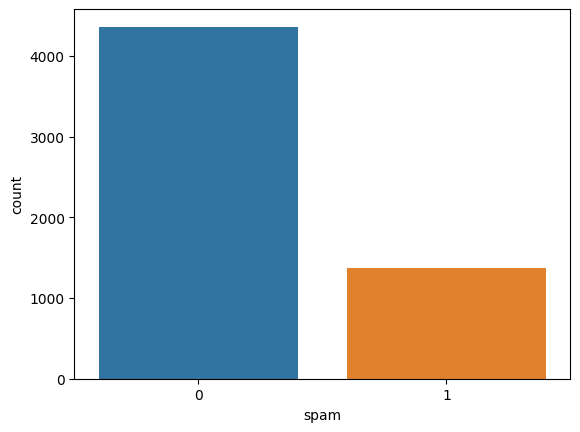

In [8]:
sns.countplot(x='spam', data=data)
plt.show()

We can clearly see that number of samples of Ham is much more than that of Spam which implies that the dataset we are using is imbalanced. 

Text(0.5, 0, 'Message types')

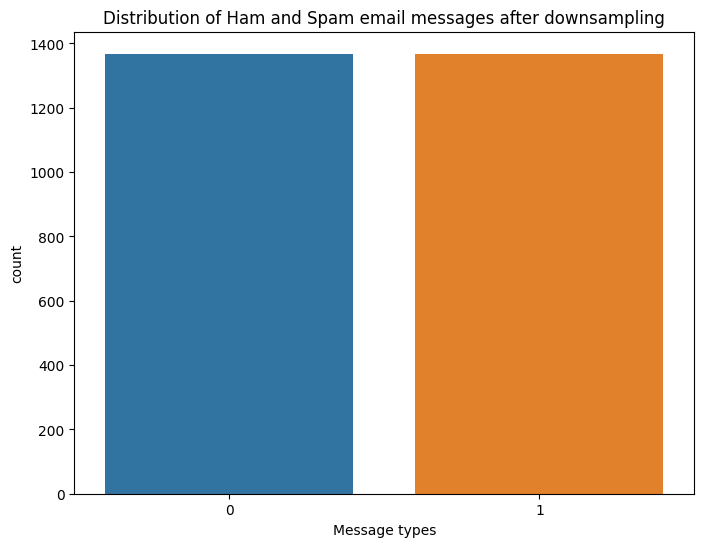

In [10]:
# Downsampling to balance the dataset
ham_msg = data[data.spam == 0]
spam_msg = data[data.spam == 1]
ham_msg = ham_msg.sample(n=len(spam_msg),random_state=42)

# Plotting the counts of down sampled dataset
balanced_data = ham_msg.append(spam_msg)\
.reset_index(drop=True)
plt.figure(figsize=(8, 6))
sns.countplot(data = balanced_data, x='spam')
plt.title('Distribution of Ham and Spam email messages after downsampling')
plt.xlabel('Message types')


In [11]:
balanced_data.shape

(2736, 2)

Text Preprocessing<br>
Textual data is highly unstructured and need attention in many aspects:

Stopwords Removal<br>
Punctuations Removal<br>
Stemming or Lemmatization<br>
Although removing data means loss of information we need to do this to make the data perfect to feed into a machine learning model.

In [12]:
balanced_data['text'] = balanced_data['text'].str.replace('Subject', '')
balanced_data.head()

,text,spam
0,: interview schedule for jinbaek kim i didn '...,0
1,": re : wednesday meeting eric , i think we c...",0
2,: re : london research group i ' d do it as s...,0
3,": re : congratulations vince , thanks for you...",0
4,: osman sezgen steve kromer is requesting tha...,0


In [13]:
punctuations_list = string.punctuation
def remove_punctuations(text):
	temp = str.maketrans('', '', punctuations_list)
	return text.translate(temp)

balanced_data['text']= balanced_data['text'].apply(lambda x: remove_punctuations(x))
balanced_data.head()


,text,spam
0,interview schedule for jinbaek kim i didn t...,0
1,re wednesday meeting eric i think we can ...,0
2,re london research group i d do it as soon...,0
3,re congratulations vince thanks for your n...,0
4,osman sezgen steve kromer is requesting that...,0


In [14]:
#The below function is a helper function that will help us to remove the stop words.
def remove_stopwords(text):
	stop_words = stopwords.words('english')

	imp_words = []

	# Storing the important words
	for word in str(text).split():
		word = word.lower()

		if word not in stop_words:
			imp_words.append(word)

	output = " ".join(imp_words)

	return output


balanced_data['text'] = balanced_data['text'].apply(lambda text: remove_stopwords(text))
balanced_data.head()


,text,spam
0,interview schedule jinbaek kim see went happy ...,0
1,wednesday meeting eric think skip meeting disc...,0
2,london research group soon possible call exact...,0
3,congratulations vince thanks note congratulati...,0
4,osman sezgen steve kromer requesting osman spe...,0


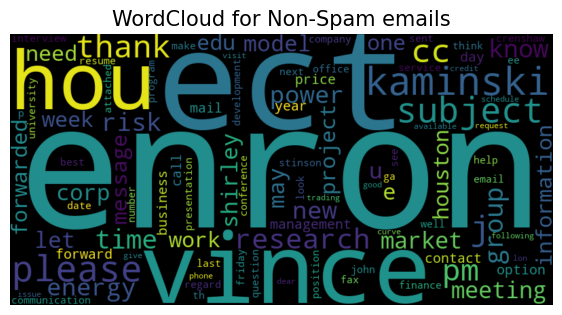

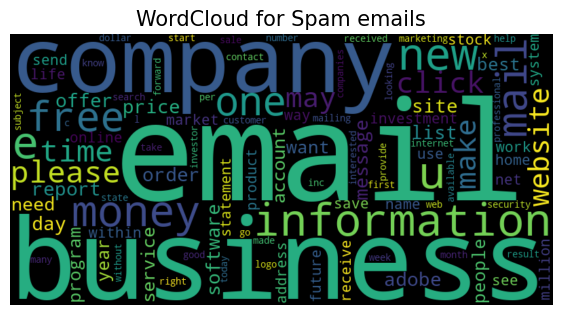

In [15]:
#A word cloud is a text visualization tool that help’s us to get insights into the most 
#frequent words present in the corpus of the data.
def plot_word_cloud(data, typ):
	email_corpus = " ".join(data['text'])

	plt.figure(figsize=(7, 7))

	wc = WordCloud(background_color='black',
				max_words=100,
				width=800,
				height=400,
				collocations=False).generate(email_corpus)

	plt.imshow(wc, interpolation='bilinear')
	plt.title(f'WordCloud for {typ} emails', fontsize=15)
	plt.axis('off')
	plt.show()

plot_word_cloud(balanced_data[balanced_data['spam'] == 0], typ='Non-Spam')
plot_word_cloud(balanced_data[balanced_data['spam'] == 1], typ='Spam')


Word2Vec Conversion<br>
We cannot feed words to a machine learning model because they work on numbers only. So, first, we will convert our words to vectors with the token IDs to the corresponding words and after padding them our textual data will arrive to a stage where we can feed it to a model.

In [17]:
#train test split
train_X, test_X, train_Y, test_Y = train_test_split(balanced_data['text'],balanced_data['spam'],test_size = 0.2,random_state = 42)
print(train_X)
print()
print(test_X)
print()
print(train_Y)
print()
print(test_Y)

247     visible red mike roberts hou ect jose marquez ...
2488    happy size sexual performance experience power...
2318    lock clients gains winning combination market ...
347     energy derivative courses dear vince grant goo...
1090    lng meeting bjorn lng meeting held tomorrow 17...
                              ...                        
1638    iso 8859 1 q automated reply administrator vak...
1095    powerisk 2000 cocktail info forwarded iona mac...
1130    new value lab fyi ajo forwarded amy oberg hou ...
1294    craig thanks feedback received similar reports...
860     employment authorization hi vince last evening...
Name: text, Length: 2188, dtype: object

719     ibuyit form attached please find completed for...
1551    going hi u sarah gal hiding want hang talk wou...
410     hyundai merchant marine lng draft dash jeff th...
1788    winning one chopard feel triumph wrist beautie...
507     2000 projects order better understand research...
                              .

We have fitted the tokenizer on our training data we will use it to convert the training and validation data both to vectors.

In [18]:
# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_X)

# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(train_X)
test_sequences = tokenizer.texts_to_sequences(test_X)

# Pad sequences to have the same length
max_len = 100 # maximum sequence length
train_sequences = pad_sequences(train_sequences,maxlen=max_len,padding='post',truncating='post')

test_sequences = pad_sequences(test_sequences,maxlen=max_len,padding='post',truncating='post')


### Model Development and Evaluation
We will implement a Sequential model which will contain the following parts:<br>

* Three Embedding Layers to learn featured vector representations of the input vectors.
* An LSTM layer to identify useful patterns in the sequence.
* Then we will have one fully connected layer.
* The final layer is the output layer which outputs probabilities for the two classes. 

In [19]:
# Build the model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1,
									output_dim=32,
									input_length=max_len))
model.add(tf.keras.layers.LSTM(16))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 32)           805024    
                                                                 
 lstm (LSTM)                 (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 32)                544       
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 808737 (3.09 MB)
Trainable params: 808737 (3.09 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


While compiling a model we provide these three essential parameters:<br>

* optimizer – This is the method that helps to optimize the cost function by using gradient descent.
* loss – The loss function by which we monitor whether the model is improving with training or not.
* metrics – This helps to evaluate the model by predicting the training and the validation data.

In [20]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
			metrics = ['accuracy'],
			optimizer = 'adam')


Callback<br>
Callbacks are used to check whether the model is improving with each epoch or not. If not then what are the necessary steps to be taken like ReduceLROnPlateau decreases the learning rate further? Even then if model performance is not improving then training will be stopped by EarlyStopping. We can also define some custom callbacks to stop training in between if the desired results have been obtained early.

In [21]:
es = EarlyStopping(patience=3,
				monitor = 'val_accuracy',
				restore_best_weights = True)

lr = ReduceLROnPlateau(patience = 2,
					monitor = 'val_loss',
					factor = 0.5,
					verbose = 0)


In [22]:
# Train the model
history = model.fit(train_sequences, train_Y,
					validation_data=(test_sequences, test_Y),
					epochs=20,
					batch_size=32,
					callbacks = [lr, es]
				)


Epoch 1/20
69/69 [==============================] - 8s 69ms/step - loss: 0.6330 - accuracy: 0.6426 - val_loss: 0.3568 - val_accuracy: 0.9234 - lr: 0.0010
Epoch 2/20
69/69 [==============================] - 3s 48ms/step - loss: 0.1949 - accuracy: 0.9666 - val_loss: 0.1170 - val_accuracy: 0.9745 - lr: 0.0010
Epoch 3/20
69/69 [==============================] - 3s 44ms/step - loss: 0.0767 - accuracy: 0.9863 - val_loss: 0.1125 - val_accuracy: 0.9763 - lr: 0.0010
Epoch 4/20
69/69 [==============================] - 3s 43ms/step - loss: 0.0485 - accuracy: 0.9918 - val_loss: 0.1057 - val_accuracy: 0.9799 - lr: 0.0010
Epoch 5/20
69/69 [==============================] - 3s 42ms/step - loss: 0.0479 - accuracy: 0.9918 - val_loss: 0.0970 - val_accuracy: 0.9818 - lr: 0.0010
Epoch 6/20
69/69 [==============================] - 3s 45ms/step - loss: 0.0366 - accuracy: 0.9945 - val_loss: 0.0815 - val_accuracy: 0.9854 - lr: 0.0010
Epoch 7/20
69/69 [==============================] - 3s 46ms/step - loss: 0.0

In [23]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_sequences, test_Y)
print('Test Loss :',test_loss)
print('Test Accuracy :',test_accuracy)


18/18 [==============================] - 0s 15ms/step - loss: 0.0815 - accuracy: 0.9854
Test Loss : 0.0815017819404602
Test Accuracy : 0.985401451587677


Model Evaluation Results<br>
Having trained our model, we can plot a graph depicting the variance of training and validation accuracies with the no. of epochs.

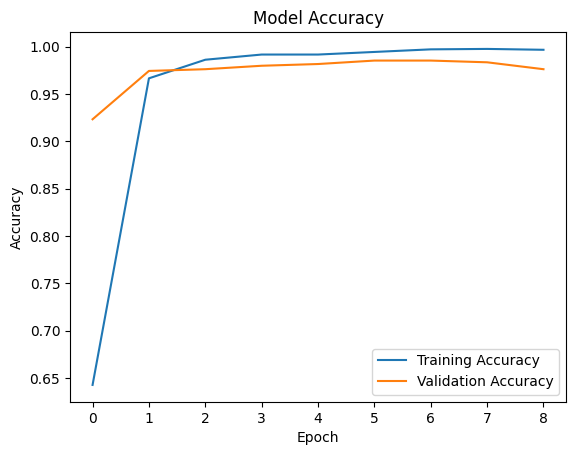

In [25]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()
